In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import loadmat
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Entropy of Real Cell

In [28]:
def Entropy(rstate, binnum, overlap = True):
    rstate[rstate>1] = 1
    wordsCollection = []
    if overlap:
        for i in np.arange(0,len(rstate)-binnum+1):
            wordsCollection.append(rstate[i:i+binnum])
    else:
        for i in np.arange(0,len(rstate)-binnum+1,binnum):
            wordsCollection.append(rstate[i:i+binnum])
    _, index = np.unique(np.array(wordsCollection), axis = 0, return_inverse=True)
    N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
    P = N/np.sum(N)
    entropy = -np.sum(P*np.log2(P))
    return entropy

# Load Data and Check Input

In [55]:
dt = 0.01

annots = loadmat('D:\\GoogleDrive\\retina\\Exps\\2021\\1103\\SplitData\\diode_repeat_OU_tau=500ms_cutoff=1_mean=13_C=0.3_03-Nov-2021_0', squeeze_me = True)
sampling_rate = 20000
TimeStamps = annots['TimeStamps']
x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
x = x[::int(sampling_rate*dt)]
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)
T = np.arange(len(x))*dt

# Spike_Cell = [0]*60
# for channelnumber in np.arange(1,61):
channelnumber = 53
Spike = annots['Spikes'][channelnumber-1]
Spike = Spike[np.where(Spike>TimeStamps[0])[0][0]:np.where(Spike<TimeStamps[1])[0][-1]]-TimeStamps[0]

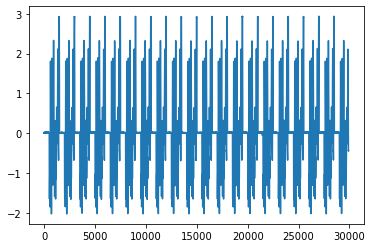

In [56]:
plt.plot(x)

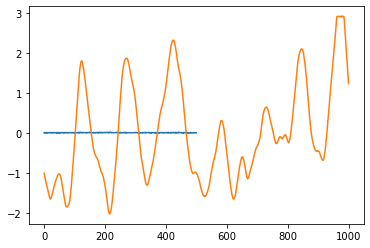

In [57]:
restTime = 5
stiTime = 10
trial = 20

plt.plot(x[:int(restTime/dt)])
plt.plot(x[int(restTime/dt):int((restTime+stiTime)/dt)])

# Information (R_info)

In [58]:
def R_info(rstate_trial, binnum, overlap = False):
    rstate_trial = np.array(rstate_trial)
    wordsCollection = []
    for rstate in rstate_trial:
        rstate[rstate>1] = 1
        if overlap:
            for i in np.arange(0,len(rstate)-binnum+1):
                wordsCollection.append(rstate[i:i+binnum])
        else:
            for i in np.arange(0,len(rstate)-binnum+1,binnum):
                wordsCollection.append(rstate[i:i+binnum])
    _, index = np.unique(np.array(wordsCollection), axis = 0, return_inverse=True)
    N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
    P = N/np.sum(N)
    totalEntropy = -np.sum(P*np.log2(P))

    trial_num = rstate_trial.shape[0]
    event_num = int(len(wordsCollection)/rstate_trial.shape[0])

    subEntropy = 0
    for i in range(event_num):
        subSet = []
        for j in range(trial_num):
            subSet.append(wordsCollection[event_num*j+i])
        _, index = np.unique(np.array(subSet), axis = 0, return_inverse=True)
        N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
        P = N/np.sum(N)
        subEntropy += -np.sum(P*np.log2(P))
    
    noiseEntropy = subEntropy/event_num
    return totalEntropy, noiseEntropy

In [59]:
def R_info2(rstate_trial):
    rstate_trial = np.array(rstate_trial)
    rstate = rstate_trial.flatten()
    N, _ = np.histogram(rstate,bins=np.append(np.unique(rstate),max(rstate)))
    P = N/np.sum(N)
    totalEntropy = -np.sum(P*np.log2(P))

    subEntropy = 0
    for i in range(rstate_trial.shape[1]):
        rstate = rstate_trial[:,i]
        N, _ = np.histogram(rstate,bins=np.append(np.unique(rstate),max(rstate)))
        P = N/np.sum(N)
        subEntropy += -np.sum(P*np.log2(P))
    
    noiseEntropy = subEntropy/rstate_trial.shape[1]
    return totalEntropy, noiseEntropy

In [60]:
binLen = dt/10
binNum = 10

## Cut Trial (Stimulus)

In [75]:
Spike_Trial = [0]*trial
rstate_Trial = [0]*trial
for i in range(trial):
    startTime = restTime+i*(restTime+stiTime)
    endTime = (i+1)*(restTime+stiTime)
    Spike_Trial[i] = Spike[np.where(Spike>=startTime)[0][0]:np.where(Spike<endTime)[0][-1]]-startTime
    rstate_Trial[i], _ = np.histogram(Spike_Trial[i], np.arange(0,stiTime+binLen,binLen))

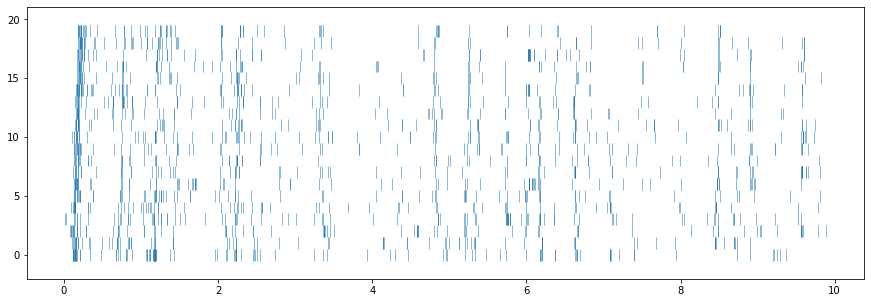

In [76]:
fig, ax = plt.subplots()
ax.eventplot(Spike_Trial, linewidths=0.5)
fig.set_size_inches(15, 5)

In [77]:
totalEntropy, noiseEntropy = R_info(rstate_Trial, binNum)
totalEntropy, noiseEntropy, totalEntropy-noiseEntropy, (totalEntropy-noiseEntropy)/totalEntropy

(0.5946328627975842,
 0.3303280767996404,
 0.2643047859979438,
 0.44448398757253754)

In [64]:
for i in range(trial):
    rstate_Trial[i], _ = np.histogram(Spike_Trial[i], np.arange(0,stiTime+dt,dt))
totalEntropy, noiseEntropy = R_info2(rstate_Trial)
totalEntropy, noiseEntropy, totalEntropy-noiseEntropy, (totalEntropy-noiseEntropy)/totalEntropy

(0.3907369898884308,
 0.2714338915771581,
 0.11930309831127273,
 0.30532839582282184)

## Cut Trial (Rest)

In [78]:
Spike_Trial = [0]*trial
rstate_Trial = [0]*trial
for i in range(trial):
    startTime = i*(restTime+stiTime)+1
    endTime = i*(restTime+stiTime)+restTime
    Spike_Trial[i] = Spike[np.where(Spike>=startTime)[0][0]:np.where(Spike<endTime)[0][-1]]-startTime
    rstate_Trial[i], _ = np.histogram(Spike_Trial[i], np.arange(0,stiTime+binLen,binLen))

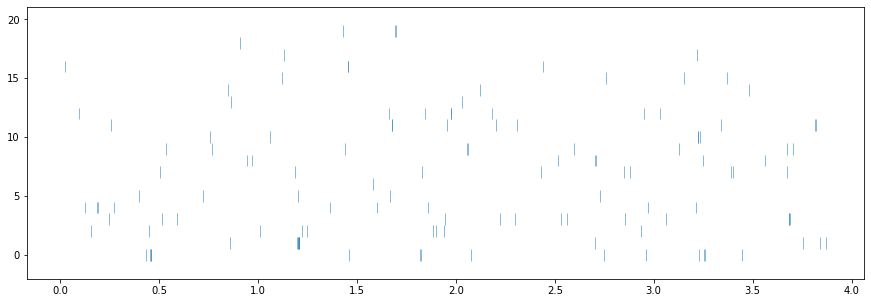

In [79]:
fig, ax = plt.subplots()
ax.eventplot(Spike_Trial, linewidths=0.5)
fig.set_size_inches(15, 5)

In [80]:
totalEntropy, noiseEntropy = R_info(rstate_Trial, binNum)
totalEntropy, noiseEntropy, totalEntropy-noiseEntropy, (totalEntropy-noiseEntropy)/totalEntropy

(0.0697809405129662,
 0.031740684071517006,
 0.03804025644144919,
 0.5451382019475766)